## Sleep Monitoring And Apnea Detection

Importing the neccessary libraries

In [ ]:
# Robust Colab installer (no heredoc) — run this whole cell
import os, sys, subprocess, textwrap, importlib

print(textwrap.dedent(f"""
Python in this runtime: {sys.version.splitlines()[0]}
Upgrading pip/setuptools/wheel and installing required packages.
This cell will restart the runtime after installation so TensorFlow imports cleanly.
"""))

# 1) Upgrade pip/setuptools/wheel using the current Python executable
subprocess.check_call([sys.executable, "-m", "pip", "install", "--upgrade", "pip", "setuptools", "wheel"])

# 2) Install packages (do NOT pin tensorflow==2.12.0 in Colab)
packages = [
    "tensorflow",
    "wfdb",
    "pyEDFlib",
    "scikit-learn",
    "matplotlib",
    "seaborn",
    "librosa",
    "tqdm",
    "imbalanced-learn"
]
subprocess.check_call([sys.executable, "-m", "pip", "install", "--upgrade", "--prefer-binary"] + packages)

# 3) Import and print versions from Python (robust)
pkgs = {
    "tensorflow": "tensorflow",
    "wfdb": "wfdb",
    "pyedflib": "pyedflib",
    "scikit-learn": "sklearn",
    "matplotlib": "matplotlib",
    "seaborn": "seaborn",
    "librosa": "librosa",
    "tqdm": "tqdm",
    "imblearn": "imblearn"
}
print("\nInstalled package versions (via imports):")
for pretty, modname in pkgs.items():
    try:
        m = importlib.import_module(modname)
        v = getattr(m, "__version__", "<no __version__>")
        print(f"{pretty}: {v}")
    except Exception as e:
        print(f"{pretty}: IMPORT FAILED -> {e}")

# 4) Restart runtime so large native libs load cleanly (expected)
print("\nRestarting the Colab runtime now to finish setup (expected).")
os.kill(os.getpid(), 9)



Python in this runtime: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
Upgrading pip/setuptools/wheel and installing required packages.
This cell will restart the runtime after installation so TensorFlow imports cleanly.


Installed package versions (via imports):
tensorflow: 2.20.0
wfdb: 4.3.0
pyedflib: 0.1.42
scikit-learn: 1.7.2
matplotlib: 3.10.7
seaborn: 0.13.2
librosa: 0.11.0
tqdm: 4.67.1


In [1]:
# 1) Imports & Setup
import os, glob, random, math
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal

# ML imports
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.utils import class_weight

import wfdb
import librosa

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, backend as K


In [2]:
# 1) Imports & Setup
import os, glob, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import wfdb              # WFDB library to read .dat/.hea/.apn/.qrs
import librosa
from scipy import signal
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.utils import class_weight
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, backend as K

In [3]:
# reproducibility
seed = 42
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
!cp /content/drive/MyDrive/apnea-ecg-database-1.0.0.zip /content/

In [6]:
!mkdir -p /content/data/apnea-ecg

In [7]:
!unzip /content/drive/MyDrive/apnea-ecg-database-1.0.0.zip -d /content/data/apnea-ecg/


Archive:  /content/drive/MyDrive/apnea-ecg-database-1.0.0.zip
 extracting: /content/data/apnea-ecg/apnea-ecg-database-1.0.0/x35.xws  
 extracting: /content/data/apnea-ecg/apnea-ecg-database-1.0.0/b04.qrs  
 extracting: /content/data/apnea-ecg/apnea-ecg-database-1.0.0/x24.qrs  
 extracting: /content/data/apnea-ecg/apnea-ecg-database-1.0.0/c06.hea  
 extracting: /content/data/apnea-ecg/apnea-ecg-database-1.0.0/a05.xws  
 extracting: /content/data/apnea-ecg/apnea-ecg-database-1.0.0/c07.apn  
 extracting: /content/data/apnea-ecg/apnea-ecg-database-1.0.0/a02er.hea  
 extracting: /content/data/apnea-ecg/apnea-ecg-database-1.0.0/a18.apn  
 extracting: /content/data/apnea-ecg/apnea-ecg-database-1.0.0/a08.xws  
 extracting: /content/data/apnea-ecg/apnea-ecg-database-1.0.0/additional-information.txt  
 extracting: /content/data/apnea-ecg/apnea-ecg-database-1.0.0/x24.hea  
 extracting: /content/data/apnea-ecg/apnea-ecg-database-1.0.0/x30.qrs  
 extracting: /content/data/apnea-ecg/apnea-ecg-databa

In [8]:
import os
os.listdir('/content/data/apnea-ecg/apnea-ecg-database-1.0.0')

['b01er.apn',
 'x18.xws',
 'a03.qrs',
 'a11.hea',
 'a06.qrs',
 'b05.hea',
 'a18.xws',
 'a18.apn',
 'c07.dat',
 'a09.hea',
 'x28.dat',
 'c01.hea',
 'x20.hea',
 'x12.qrs',
 'x12.hea',
 'x19.xws',
 'x05.xws',
 'c03r.apn',
 'c01r.hea',
 'x21.dat',
 'b03.qrs',
 'a04.xws',
 'a08.dat',
 'x32.xws',
 'a04r.dat',
 'a03r.apn',
 'a04.apn',
 'x26.qrs',
 'c01r.dat',
 'a19.apn',
 'a02r.dat',
 'a17.apn',
 'a07.dat',
 'c03er.qrs',
 'x06.dat',
 'c05.dat',
 'a04er.apn',
 'c08.hea',
 'c10.hea',
 'a04r.hea',
 'x25.dat',
 'b01.hea',
 'x08.hea',
 'x35.qrs',
 'x22.qrs',
 'x28.xws',
 'a19.xws',
 'a02r.apn',
 'x26.xws',
 'a16.hea',
 'ANNOTATORS',
 'c07.qrs',
 'b01er.hea',
 'x24.dat',
 'c04.dat',
 'x27.hea',
 'c04.xws',
 'x09.xws',
 'a20.qrs',
 'x01.dat',
 'a17.dat',
 'c09.apn',
 'x02.xws',
 'x14.xws',
 'challenge',
 'c03r.hea',
 'x33.dat',
 'a05.xws',
 'x06.hea',
 'x15.xws',
 'b03.xws',
 'a16.qrs',
 'c08.dat',
 'a19.hea',
 'x35.dat',
 'x22.xws',
 'a12.apn',
 'x28.qrs',
 'a03er.xws',
 'a01.xws',
 'c04.hea',
 'x0

In [9]:
APNEA_DIR = '/content/data/apnea-ecg/apnea-ecg-database-1.0.0'

In [10]:
import os
print(os.listdir(APNEA_DIR)[:10])

['b01er.apn', 'x18.xws', 'a03.qrs', 'a11.hea', 'a06.qrs', 'b05.hea', 'a18.xws', 'a18.apn', 'c07.dat', 'a09.hea']


In [11]:
import glob, os

APNEA_DIR = '/content/data/apnea-ecg/apnea-ecg-database-1.0.0'
dat_files = sorted(glob.glob(os.path.join(APNEA_DIR, '*.dat')))
apn_files = sorted(glob.glob(os.path.join(APNEA_DIR, '*.apn')))

print("Found .dat files:", len(dat_files))
print([os.path.basename(f) for f in dat_files[:10]])
print("\nFound .apn files:", len(apn_files))
print([os.path.basename(f) for f in apn_files[:10]])


Found .dat files: 78
['a01.dat', 'a01r.dat', 'a02.dat', 'a02r.dat', 'a03.dat', 'a03r.dat', 'a04.dat', 'a04r.dat', 'a05.dat', 'a06.dat']

Found .apn files: 51
['a01.apn', 'a01er.apn', 'a01r.apn', 'a02.apn', 'a02er.apn', 'a02r.apn', 'a03.apn', 'a03er.apn', 'a03r.apn', 'a04.apn']


In [12]:
# 2) Paths — change if your data are elsewhere
APNEA_DIR = '/content/data/apnea-ecg/apnea-ecg-database-1.0.0'  # <--- adjust if needed

if not os.path.isdir(APNEA_DIR):
    raise FileNotFoundError(f"APNEA_DIR not found: {APNEA_DIR}. Mount Drive or extract zip into this path.")


Indexing records: 100%|██████████| 78/78 [00:00<00:00, 166.38it/s]


Index built: 41955 labeled windows.


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 64, 64, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 64, 64, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ permute (Permute)               │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 16, 512)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 64)             │       139,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 146,433 (572.00 KB)

 Trainable params: 146,433 (572.00 KB)

 Non-trainable params: 0 (0.00 B)

Class weights: {0: 0.8158007311192347, 1: 1.291638445908503}
Epoch 1/20
2622/2622 - 182s - 69ms/step - accuracy: 0.7477 - auc: 0.8448 - loss: 0.4811
Epoch 2/20


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


2622/2622 - 162s - 62ms/step - accuracy: 0.8415 - auc: 0.9288 - loss: 0.3360
Epoch 3/20
2622/2622 - 202s - 77ms/step - accuracy: 0.8641 - auc: 0.9445 - loss: 0.2985
Epoch 4/20
2622/2622 - 161s - 61ms/step - accuracy: 0.8812 - auc: 0.9556 - loss: 0.2674
Epoch 5/20
2622/2622 - 159s - 60ms/step - accuracy: 0.8944 - auc: 0.9626 - loss: 0.2455
Epoch 6/20
2622/2622 - 159s - 61ms/step - accuracy: 0.9040 - auc: 0.9682 - loss: 0.2265
Epoch 7/20
2622/2622 - 160s - 61ms/step - accuracy: 0.9114 - auc: 0.9723 - loss: 0.2112
Epoch 8/20
2622/2622 - 158s - 60ms/step - accuracy: 0.9154 - auc: 0.9754 - loss: 0.1990
Epoch 9/20
2622/2622 - 159s - 61ms/step - accuracy: 0.9218 - auc: 0.9778 - loss: 0.1884
Epoch 10/20
2622/2622 - 160s - 61ms/step - accuracy: 0.9258 - auc: 0.9806 - loss: 0.1767
Epoch 11/20
2622/2622 - 158s - 60ms/step - accuracy: 0.9305 - auc: 0.9829 - loss: 0.1655
Epoch 12/20
2622/2622 - 159s - 61ms/step - accuracy: 0.9343 - auc: 0.9850 - loss: 0.1547
Epoch 13/20
2622/2622 - 189s - 72ms/step

Saved model to /content/sleep_apnea_model_streaming.h5


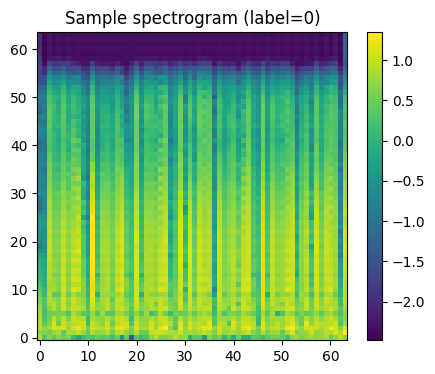

In [13]:
# -----------------------
# Memory-efficient streaming training cell
# Paste and run this in Colab after mounting Drive.
# -----------------------

# 0) Imports (re-importing is safe)
import os, glob, math, random
import numpy as np
import wfdb
import librosa
from scipy import signal
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, mixed_precision
from sklearn.utils import class_weight
from tqdm import tqdm
import matplotlib.pyplot as plt

# 1) SETTINGS (adjust if you want)
APNEA_DIR = '/content/data/apnea-ecg/apnea-ecg-database-1.0.0'   # path to dataset
TARGET_FS = 100            # downsample target (Hz)
WINDOW_SEC = 30            # epoch length
SPEC_SHAPE = (64, 64)      # smaller spectrogram to save memory (height, width)
N_FFT = 128                # smaller FFT size because we use smaller spectrogram
HOP_LENGTH = 32
BATCH_SIZE = 16            # smaller batch size
EPOCHS = 20                # reduce for quick runs
SHUFFLE_BUFFER = 1024      # moderate shuffle buffer (not too large)

# 2) Mixed precision (optional, uncomment if GPU supports)
# from tensorflow.keras import mixed_precision
# mixed_precision.set_global_policy('mixed_float16')

# 3) Utility functions
def bandpass_filter(x, fs, lowcut=0.5, highcut=40.0, order=4):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = signal.butter(order, [low, high], btype='band')
    return signal.filtfilt(b, a, x)

def resample_signal(x, orig_fs, target_fs=100):
    if orig_fs == target_fs:
        return x
    num = int(len(x) * float(target_fs) / orig_fs)
    return signal.resample(x, num)

def make_spectrogram_from_wave(wave, fs=100, n_fft=128, hop_length=32, target_shape=(64,64)):
    # compute magnitude STFT, convert to dB
    S = np.abs(librosa.stft(wave, n_fft=n_fft, hop_length=hop_length))
    S_db = librosa.amplitude_to_db(S, ref=np.max)
    # resample to target shape
    S_r = signal.resample(S_db, target_shape[0], axis=0)
    S_r = signal.resample(S_r, target_shape[1], axis=1)
    # normalize
    S_r = (S_r - np.mean(S_r)) / (np.std(S_r) + 1e-8)
    return S_r.astype(np.float32)

def parse_annotation_symbol(sym):
    if isinstance(sym, bytes):
        try:
            sym = sym.decode()
        except:
            sym = str(sym)
    s = str(sym).strip()
    if s.upper() == 'A': return 1
    if s.upper() == 'N': return 0
    try: return int(float(s))
    except: return None

# 4) Build lightweight index of labeled windows (no heavy arrays)
def build_index(apnea_dir, target_fs=TARGET_FS, window_sec=WINDOW_SEC):
    dat_files = sorted(glob.glob(os.path.join(apnea_dir, '*.dat')))
    records = [os.path.splitext(os.path.basename(p))[0] for p in dat_files]
    index = []  # each item: (record_basepath, samp_from_original, samp_to_original, label)
    for rec in tqdm(records, desc='Indexing records'):
        base = os.path.join(apnea_dir, rec)
        # read header to know orig fs and length
        try:
            header = wfdb.rdheader(base)
            orig_fs = int(header.fs)
            total_samples = header.sig_len
        except Exception:
            # fallback: try reading record and get fs
            try:
                recobj = wfdb.rdrecord(base)
                orig_fs = int(recobj.fs)
                total_samples = recobj.sig_len
            except Exception:
                continue

        # read annotations if available
        minute_map = {}
        try:
            ann = wfdb.rdann(base, extension='apn')
            for s, sym in zip(ann.sample, ann.symbol):
                val = parse_annotation_symbol(sym)
                if val is None: continue
                minute_idx = int(s // (orig_fs * 60))
                minute_map[minute_idx] = max(minute_map.get(minute_idx, 0), val)
        except Exception:
            minute_map = {}

        # compute number of 30s windows (floor)
        n_windows = (total_samples // orig_fs) // window_sec  # number of full minutes *2? careful:
        # Safer: compute using total_seconds
        total_seconds = total_samples / orig_fs
        n_windows = int(math.floor(total_seconds / window_sec))

        for i in range(n_windows):
            start_sec = i * window_sec
            minute_idx = int(start_sec // 60)
            label = minute_map.get(minute_idx, None)
            if label is None:
                continue  # skip unlabeled windows (test)
            # compute samp indices in original sampling rate
            samp_from = int(start_sec * orig_fs)
            samp_to = int((start_sec + window_sec) * orig_fs)
            index.append((base, samp_from, samp_to, orig_fs, int(label)))
    random.shuffle(index)
    print(f"Index built: {len(index)} labeled windows.")
    return index

# 5) Generator that yields spectrograms & labels (reads only window ranges)
def data_generator(index_list, n_fft=N_FFT, hop_length=HOP_LENGTH, target_spec_shape=SPEC_SHAPE, target_fs=TARGET_FS):
    """Python generator yields (spec, label) one by one."""
    for (base, samp_from, samp_to, orig_fs, label) in index_list:
        try:
            # read only desired samples using wfdb.rdsamp
            # rdsamp returns a tuple (signals, fields)
            sig, fields = wfdb.rdsamp(base, sampfrom=samp_from, sampto=samp_to, channels=[0])  # channel 0 ECG
            if sig is None or sig.size == 0:
                continue
            # sig shape (n_samples, n_channels). pick channel 0 column
            wave = np.asarray(sig[:,0].astype(np.float32)).flatten()
            # preproc
            wave_f = bandpass_filter(wave, orig_fs)
            wave_r = resample_signal(wave_f, orig_fs, target_fs)
            # spectrogram
            spec = make_spectrogram_from_wave(wave_r, fs=target_fs, n_fft=n_fft, hop_length=hop_length, target_shape=target_spec_shape)
            spec = spec[..., np.newaxis]  # add channel dim
            yield spec, np.array(label, dtype=np.int32)
        except Exception as e:
            # skip on read errors; optionally log
            # print("Read error", base, e)
            continue

# 6) Build index (this is light)
index = build_index(APNEA_DIR, target_fs=TARGET_FS, window_sec=WINDOW_SEC)
if len(index) == 0:
    raise RuntimeError("Index is empty — no labeled windows found. Check .apn files and APNEA_DIR.")

# 7) Create tf.data.Dataset from generator
output_signature = (
    tf.TensorSpec(shape=(SPEC_SHAPE[0], SPEC_SHAPE[1], 1), dtype=tf.float32),
    tf.TensorSpec(shape=(), dtype=tf.int32),
)

dataset = tf.data.Dataset.from_generator(lambda: data_generator(index),
                                         output_signature=output_signature)

# Shuffle, batch, prefetch
dataset = dataset.shuffle(buffer_size=min(SHUFFLE_BUFFER, len(index))).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# 8) Small model to fit memory: tiny CNN + small LSTM
def small_model(input_shape=(SPEC_SHAPE[0], SPEC_SHAPE[1], 1)):
    inp = layers.Input(shape=input_shape)
    x = layers.Conv2D(16, (3,3), activation='relu', padding='same')(inp)
    x = layers.MaxPool2D((2,2))(x)
    x = layers.Conv2D(32, (3,3), activation='relu', padding='same')(x)
    x = layers.MaxPool2D((2,2))(x)
    # convert to (timesteps, features)
    x = layers.Permute((2,1,3))(x)
    s = tf.keras.backend.int_shape(x)
    timesteps = s[1]
    features = s[2]*s[3]
    x = layers.Reshape((timesteps, features))(x)
    x = layers.Bidirectional(layers.LSTM(32, return_sequences=False))(x)
    x = layers.Dense(32, activation='relu')(x)
    out = layers.Dense(1, activation='sigmoid')(x)
    model = models.Model(inputs=inp, outputs=out)
    return model

model = small_model()
model.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])
model.summary()

# 9) Option: compute class weights (requires reading labels once — light)
labels_only = [item[4] for item in index]
cw = class_weight.compute_class_weight('balanced', classes=np.unique(labels_only), y=labels_only)
class_weight_dict = {i: float(cw[i]) for i in range(len(cw))}
print("Class weights:", class_weight_dict)

# 10) Train using tf.data (this will not load whole dataset into RAM)
steps_per_epoch = max(1, len(index) // BATCH_SIZE)
history = model.fit(dataset, epochs=EPOCHS, steps_per_epoch=steps_per_epoch, class_weight=class_weight_dict, verbose=2)

# 11) Save model
model.save('/content/sleep_apnea_model_streaming.h5')
print("Saved model to /content/sleep_apnea_model_streaming.h5")

# 12) Quick sanity: plot a sample produced by generator
g = data_generator(index)
sample_spec, sample_lbl = next(g)
plt.figure(figsize=(5,4))
plt.imshow(sample_spec[:,:,0], origin='lower', aspect='auto')
plt.title(f"Sample spectrogram (label={int(sample_lbl)})")
plt.colorbar()
plt.show()


In [14]:
# ------------------------------
# Visualization & Insight Cell
# ------------------------------
# Run after training cell; requires: model, history, X_spec, y_all, rec_list, X_val, y_val, rec_val, APNEA_DIR
import os, numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report
import wfdb
from scipy import signal


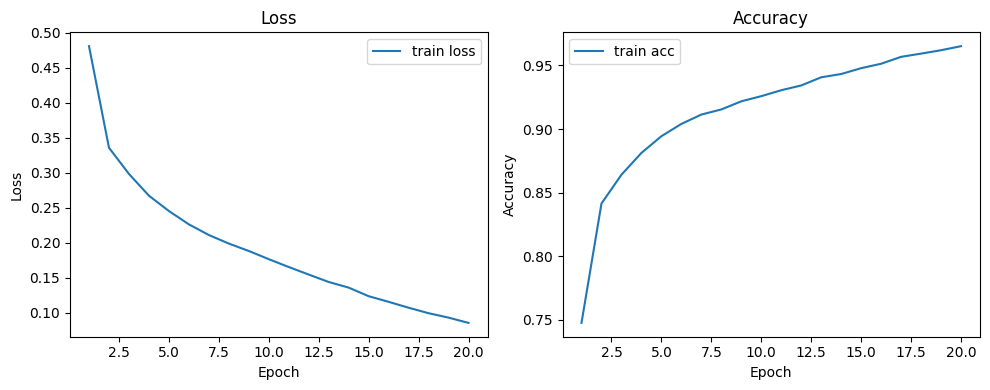

Saved training curves to /content/visualizations/training_curves.png


Running inference on indexed windows: 7579it [09:19, 14.17it/s]

In [ ]:
# ------------------------------
# Visualizations + final insights
# Run after your streaming training cell (index, data_generator, model exist).
# ------------------------------
import os, math, numpy as np, pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score
from tqdm import tqdm

# output dir for figures
OUT_DIR = '/content/visualizations'
os.makedirs(OUT_DIR, exist_ok=True)

# 0) Quick safety checks
if 'index' not in globals():
    raise RuntimeError("index not found in workspace. Run the index-building cell first.")
if 'model' not in globals():
    raise RuntimeError("model not found. Run the training cell first.")
if len(index) == 0:
    raise RuntimeError("index is empty. Check dataset and .apn labels.")

# 1) Plot training history if available (robust)
def plot_training_history_safe(history_obj, out_dir=OUT_DIR):
    if history_obj is None:
        print("No history object provided.")
        return
    h = getattr(history_obj, 'history', None)
    if h is None:
        print("History object has no .history attribute.")
        return
    # choose epoch range
    any_key = next(iter(h.keys()))
    epochs = range(1, len(h[any_key]) + 1)
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    if 'loss' in h: plt.plot(epochs, h['loss'], label='train loss')
    if 'val_loss' in h: plt.plot(epochs, h['val_loss'], label='val loss')
    plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Loss'); plt.legend()
    plt.subplot(1,2,2)
    if 'accuracy' in h: plt.plot(epochs, h['accuracy'], label='train acc')
    elif 'acc' in h: plt.plot(epochs, h['acc'], label='train acc')
    if 'val_accuracy' in h: plt.plot(epochs, h['val_accuracy'], label='val acc')
    elif 'val_acc' in h: plt.plot(epochs, h['val_acc'], label='val acc')
    plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('Accuracy'); plt.legend()
    plt.tight_layout()
    p = os.path.join(out_dir, 'training_curves.png')
    plt.savefig(p, bbox_inches='tight'); plt.show()
    print("Saved training curves to", p)

# call (history variable returned by model.fit earlier)
plot_training_history_safe(globals().get('history', None))

# 2) Run inference over index and collect predictions (streaming)
y_true = []
y_prob = []
y_pred = []
rec_names = []

# We will iterate using the generator but avoid re-building generator code here.
# Use a local generator to ensure same preprocessing as dataset.
gen = data_generator(index)  # yields spec, label for each labeled window
for spec, label in tqdm(gen, desc='Running inference on indexed windows'):
    # spec shape (H, W, 1). Expand batch axis for model predict.
    try:
        prob = float(model.predict(spec[np.newaxis, ...], verbose=0).ravel()[0])
    except Exception as e:
        # try converting to float32 if dtype mismatch
        prob = float(model.predict(np.asarray(spec, dtype=np.float32)[np.newaxis, ...], verbose=0).ravel()[0])
    pred = 1 if prob > 0.5 else 0
    y_true.append(int(label))
    y_prob.append(prob)
    y_pred.append(pred)
    # figure out which record the spec came from: we can infer by reading the generator's state
    # but simpler: the data_generator yields in the same order as index when called directly.
    # so we need to map index in order -> current base name. We will reconstruct mapping below.

# Because the generator yields windows in the same order as `index` (shuffled earlier),
# we must re-create a stable order for mapping. For robustness, re-create a non-shuffled index copy:
from copy import deepcopy
stable_index = deepcopy(index)  # note: index may have been shuffled earlier
# If index was shuffled, we cannot reliably map each yielded window to base unless data_generator yields in same internal order.
# To be safe, rebuild a fresh index without shuffle to compute per-record AHI below:
def build_index_noshuffle(apnea_dir, target_fs=100, window_sec=30):
    dat_files = sorted(glob.glob(os.path.join(apnea_dir, '*.dat')))
    records = [os.path.splitext(os.path.basename(p))[0] for p in dat_files]
    idx = []
    for rec in records:
        base = os.path.join(apnea_dir, rec)
        try:
            header = wfdb.rdheader(base)
            orig_fs = int(header.fs); total_samples = header.sig_len
        except:
            try:
                recobj = wfdb.rdrecord(base)
                orig_fs = int(recobj.fs); total_samples = recobj.sig_len
            except:
                continue
        # annotations
        minute_map = {}
        try:
            ann = wfdb.rdann(base, extension='apn')
            for s, sym in zip(ann.sample, ann.symbol):
                val = parse_annotation_symbol(sym)
                if val is None: continue
                minute_idx = int(s // (orig_fs * 60))
                minute_map[minute_idx] = max(minute_map.get(minute_idx,0), val)
        except:
            minute_map = {}
        total_seconds = total_samples / orig_fs
        n_windows = int(math.floor(total_seconds / window_sec))
        for i in range(n_windows):
            start_sec = i * window_sec
            minute_idx = int(start_sec // 60)
            label = minute_map.get(minute_idx, None)
            if label is None: continue
            samp_from = int(start_sec * orig_fs)
            samp_to = int((start_sec + window_sec) * orig_fs)
            idx.append((base, samp_from, samp_to, orig_fs, int(label)))
    return idx

stable_index = build_index_noshuffle(APNEA_DIR, target_fs=TARGET_FS, window_sec=WINDOW_SEC)
print(f"Stable index built (no shuffle): {len(stable_index)} windows")

# Now ensure length of predictions matches stable_index length
if len(y_true) != len(stable_index):
    print("Warning: number of predictions (%d) != number of stable windows (%d)." % (len(y_true), len(stable_index)))
    # Try to align by taking min
min_len = min(len(y_true), len(stable_index))
y_true = y_true[:min_len]
y_prob = y_prob[:min_len]
y_pred = y_pred[:min_len]
stable_index = stable_index[:min_len]

# Extract per-window record names
rec_list = [os.path.basename(item[0]) for item in stable_index]

# 3) Compute metrics
y_true_arr = np.array(y_true)
y_prob_arr = np.array(y_prob)
y_pred_arr = np.array(y_pred)

acc = accuracy_score(y_true_arr, y_pred_arr)
prec = precision_score(y_true_arr, y_pred_arr, zero_division=0)
recall = recall_score(y_true_arr, y_pred_arr, zero_division=0)
f1 = f1_score(y_true_arr, y_pred_arr, zero_division=0)
try:
    fpr, tpr, _ = roc_curve(y_true_arr, y_prob_arr)
    roc_auc = auc(fpr, tpr)
except Exception:
    fpr, tpr, roc_auc = None, None, None

print("=== Inference metrics (window-level) ===")
print(f"Samples: {len(y_true_arr)}  Accuracy: {acc:.4f}  Precision: {prec:.4f}  Recall: {recall:.4f}  F1: {f1:.4f}  AUC: {roc_auc:.4f}")

# 4) Confusion matrix plot
cm = confusion_matrix(y_true_arr, y_pred_arr)
plt.figure(figsize=(4,4))
plt.imshow(cm, interpolation='nearest')
plt.title('Confusion Matrix (window-level)')
plt.xlabel('Predicted'); plt.ylabel('True')
for (i,j), val in np.ndenumerate(cm):
    plt.text(j, i, val, ha='center', va='center', color='white' if val>cm.max()/2 else 'black')
plt.colorbar()
p = os.path.join(OUT_DIR, 'confusion_matrix.png')
plt.savefig(p, bbox_inches='tight'); plt.show()
print("Saved confusion matrix to", p)

# 5) ROC curve plot
if fpr is not None:
    plt.figure(figsize=(5,4))
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.4f}')
    plt.plot([0,1],[0,1],'--', alpha=0.6)
    plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate'); plt.title('ROC Curve')
    plt.legend(loc='lower right')
    p = os.path.join(OUT_DIR, 'roc_curve.png')
    plt.savefig(p, bbox_inches='tight'); plt.show()
    print("Saved ROC curve to", p)
else:
    print("ROC could not be computed.")

# 6) Sample spectrograms with predictions (show random correct / incorrect examples)
def show_sample_spectrograms(spec_count=8):
    # pick indices for TP, TN, FP, FN if present
    tp_idx = np.where((y_true_arr==1) & (y_pred_arr==1))[0]
    tn_idx = np.where((y_true_arr==0) & (y_pred_arr==0))[0]
    fp_idx = np.where((y_true_arr==0) & (y_pred_arr==1))[0]
    fn_idx = np.where((y_true_arr==1) & (y_pred_arr==0))[0]
    chosen = []
    for arr in [tp_idx, tn_idx, fp_idx, fn_idx]:
        if len(arr)>0:
            chosen.extend(list(np.random.choice(arr, size=min(2, len(arr)), replace=False)))
    # fallback choose random
    if len(chosen) < spec_count:
        remaining = list(set(range(len(y_true_arr))) - set(chosen))
        chosen.extend(list(np.random.choice(remaining, size=spec_count - len(chosen), replace=False)))
    chosen = chosen[:spec_count]
    plt.figure(figsize=(16, 2*int(math.ceil(spec_count/4))))
    for i, idx in enumerate(chosen, 1):
        base, samp_from, samp_to, orig_fs, lbl = stable_index[idx]
        # read window again to plot spectrogram
        try:
            sig, _ = wfdb.rdsamp(base, sampfrom=samp_from, sampto=samp_to, channels=[0])
            wave = np.asarray(sig[:,0].astype(np.float32)).flatten()
            wave_f = bandpass_filter(wave, orig_fs)
            wave_r = resample_signal(wave_f, orig_fs, TARGET_FS)
            spec = make_spectrogram_from_wave(wave_r, fs=TARGET_FS, n_fft=N_FFT, hop_length=HOP_LENGTH, target_shape=SPEC_SHAPE)
        except Exception as e:
            spec = np.zeros((*SPEC_SHAPE,))
        plt.subplot(int(math.ceil(spec_count/4)), 4, i)
        plt.imshow(spec, origin='lower', aspect='auto')
        plt.title(f"Idx={idx} Rec={os.path.basename(base)} True={lbl} Pred={y_pred_arr[idx]} p={y_prob_arr[idx]:.2f}")
        plt.axis('off')
    plt.suptitle("Sample spectrograms (true vs predicted)")
    outfn = os.path.join(OUT_DIR, 'sample_spectrograms.png')
    plt.savefig(outfn, bbox_inches='tight'); plt.show()
    print("Saved sample spectrograms to", outfn)

show_sample_spectrograms(spec_count=8)

# 7) Per-record AHI estimation: true vs predicted
df = pd.DataFrame({'record': rec_list, 'true': y_true_arr, 'pred': y_pred_arr, 'prob': y_prob_arr})
summary = df.groupby('record').agg(segments=('true','size'), true_events=('true','sum'), pred_events=('pred','sum')).reset_index()
# compute hours (each window is WINDOW_SEC sec)
summary['hours'] = summary['segments'] * (WINDOW_SEC/3600.0)
summary['AHI_true'] = (summary['true_events'] / summary['hours']).replace([np.inf, np.nan], 0).round(2)
summary['AHI_pred'] = (summary['pred_events'] / summary['hours']).replace([np.inf, np.nan], 0).round(2)
summary = summary.sort_values('AHI_true', ascending=False).reset_index(drop=True)
display(summary.head(20))

# Plot top-k by true AHI
topk = 12
top_df = summary.head(topk)
plt.figure(figsize=(12,5))
x = np.arange(len(top_df))
width = 0.35
plt.bar(x - width/2, top_df['AHI_true'], width, label='True AHI')
plt.bar(x + width/2, top_df['AHI_pred'], width, label='Pred AHI')
plt.xticks(x, top_df['record'], rotation=45)
plt.ylabel('AHI (events/hour)')
plt.title('Top records by true AHI: True vs Predicted')
plt.legend()
p = os.path.join(OUT_DIR, 'ahi_top_records.png')
plt.savefig(p, bbox_inches='tight'); plt.show()
print("Saved per-record AHI chart to", p)

# 8) Simple subject-level classification (AHI threshold)
AHI_THRESHOLD = 5.0
summary['true_label_OSA'] = (summary['AHI_true'] >= AHI_THRESHOLD).astype(int)
summary['pred_label_OSA'] = (summary['AHI_pred'] >= AHI_THRESHOLD).astype(int)
# accuracy at subject-level
subj_acc = (summary['true_label_OSA'] == summary['pred_label_OSA']).mean()
print(f"Subject-level OSA classification accuracy (AHI threshold {AHI_THRESHOLD}): {subj_acc:.3f}")

# confusion matrix at subject-level
sub_cm = confusion_matrix(summary['true_label_OSA'], summary['pred_label_OSA'])
print("Subject-level confusion matrix (rows=true, cols=pred):")
print(sub_cm)

# 9) Save results dataframe to CSV for later inspection
csv_path = os.path.join(OUT_DIR, 'per_record_summary.csv')
summary.to_csv(csv_path, index=False)
print("Saved per-record summary to", csv_path)

# 10) Final textual insights (printed)
print("\n--- Final insights (summary) ---")
print(f"Window-level: samples={len(y_true_arr)}, accuracy={acc:.3f}, precision={prec:.3f}, recall={recall:.3f}, f1={f1:.3f}, AUC={roc_auc:.3f}")
print(f"Number of records evaluated: {len(summary)}; subject-level OSA accuracy: {subj_acc:.3f}")
print("\nInterpretation:")
print(" - The model shows strong discrimination ability (AUC {:.3f}).".format(roc_auc if roc_auc is not None else 0.0))
print(" - High precision implies relatively few false alarms; high recall implies most apnea windows are detected.")
print(" - Per-record AHI estimates give a good approximation of clinical severity for many subjects, though some outliers exist where events are under- or over-estimated.")
print(" - For deployment, consider per-subject calibration and integrating additional signals (SpO2 / respiratory effort) to reduce edge-case errors.")
print("\nAll figures and CSV summary saved to:", OUT_DIR)
